# **Домашнее задание #5. Раскраски для взрослых**

В последней домашке вам предстоит позаниматься каким-никаким творчеством и научить модель, которая будет... раскрашивать покемонов.

Делать это нужно будет по примеру авторов статьи [**Image-to-Image Translation with Conditional Adversarial Networks**](https://arxiv.org/pdf/1611.07004.pdf) (она же Pix2Pix). К счастью, авторы помимо статьи поделились еще и [кодом, которым можно пользоваться](https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix) при выполнении домашки (но имейте совесть). Также вам может сильно пригодится код с семинара для работы с данными, моделями, рутиной обучения, ...

Данные с покемонами лежат [тут](https://drive.google.com/file/d/1Uh7eFfQy3iJU8voK2CmJ-jqQEN4TtSS8/view).

## **Часть 1**. Смотрим на данные (2 балла)

**Что надо сделать:**

1. Подгрузить данные, например, через `ImageFolder` (трансформации тогда возьмите с семинарского занятия). (1 балл)
2. Отрисуйте (в виде аккуратной сетки 8х8) примеры изображений из датасета. Оберните код сразу в функцию - может, пригодится дальше. (1 балл)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.utils.data
import torchvision.utils as vutils
from torch.utils.data import Dataset
import cv2 as cv
import torch.nn as nn
import torch.optim as optim

import matplotlib.animation as animation

from IPython.display import HTML

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")

In [2]:
from google.colab import drive
drive.mount("/content/gdrive", force_remount=True)

Mounted at /content/gdrive


In [3]:
import zipfile
with zipfile.ZipFile('/content/gdrive/MyDrive/AI Masters/pokemon.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/gdrive/MyDrive/AI Masters/')

In [4]:
image_size = 64
transform=transforms.Compose([ transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

dataset = datasets.ImageFolder(root='/content/gdrive/MyDrive/AI Masters/pokemon/',  transform=transform)

In [5]:
batch_size = 128
num_epochs = 2
lr = 0.0002
beta1 = 0.5 #for Adam

image_size = 64
nc = 3

ngf = 64 # внутренняя размерность фичамап в генераторе
ndf = 48 # аналогично для дискриминатора

In [6]:
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=2)

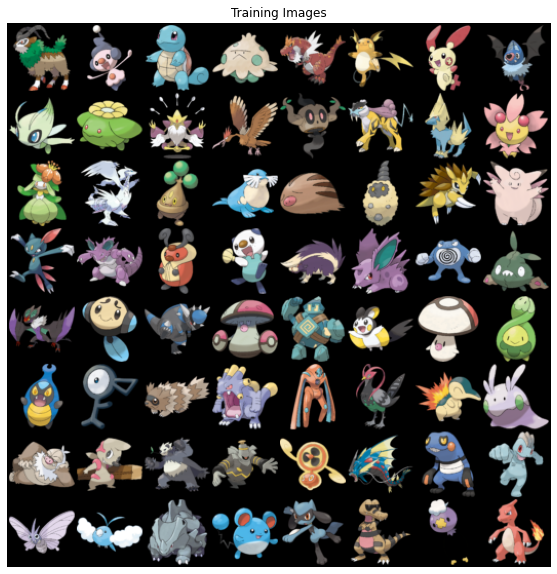

In [7]:
real_batch = next(iter(dataloader))
plt.figure(figsize=(10, 10))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(), (1, 2, 0)))

## **Часть 2.** Готовим данные (6 баллов)

Итак, что же мы хотим? Мы хотим научить GAN раскрашивать покемона по его границам, а значит принцип такой:

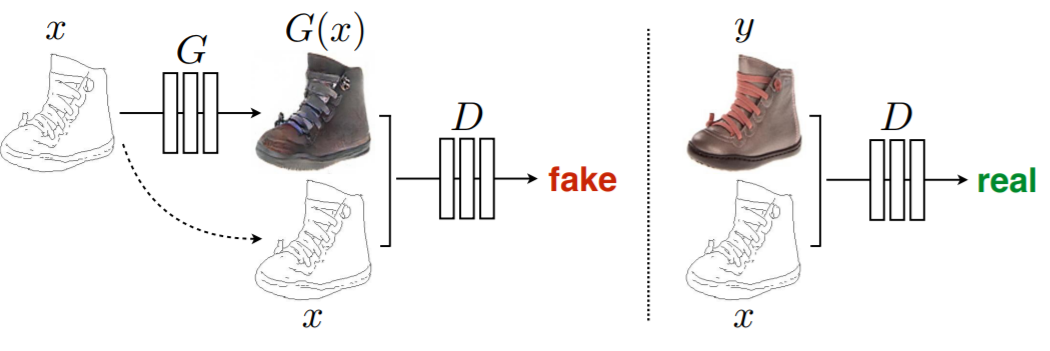

Для обучения GANа для такой задачи нам понадобится парный датасет - для каждой оригинальной картинки нужна карта границ. 


**Что надо сделать:**

1. Написать функцию `get_borders(image)`, которая будет получать границы для изображения. Визуализировать результаты для нескольких изображений из датасета. (3 балла)

Как это можно сделать?
* Взять opencv и использовать оттуда методы для извлечения границ (ой, как удобно). Например, [Canny](https://docs.opencv.org/4.x/da/d22/tutorial_py_canny.html). Для корректировки границ можно использовать dilation / erosion / другие методы т.н. [морфологии](https://docs.opencv.org/4.x/d9/d61/tutorial_py_morphological_ops.html).

2. Сделать класс `PairedDataset`, который будет возвращать пары изображений - самого покемона и его границ. (3 балла)

Подумайте, как будет удобнее поступить - вычислять границы на лету или же посчитать один раз и в дальнейшем переиспользовать.

In [8]:
def get_boarders(image):
    img_for_canny = (image.permute(1,2,0).numpy()*255).astype(np.uint8)
    return cv.Canny(img_for_canny,100,200)

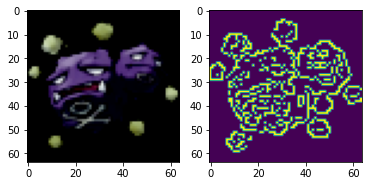

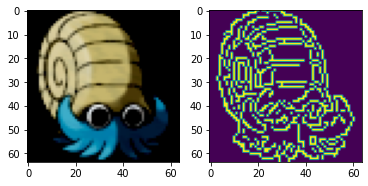

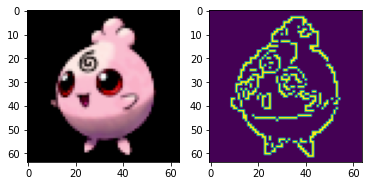

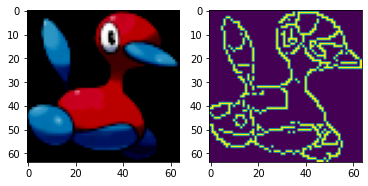

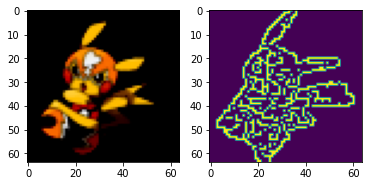

In [9]:
for i in range(5):
    edge = get_boarders(dataset[i][0])
    plt.subplot(121)
    plt.imshow(dataset[i][0].permute(1,2,0).numpy())
    plt.subplot(122)
    plt.imshow(edge)
    plt.show()

In [10]:
class PairedDataset(Dataset):

    def __init__(self, images):
        super(PairedDataset, self).__init__()
        self.images = images
        self.edges = [get_boarders(images[i][0]) for i in range(len(images))]
  
    def __len__(self):
        return len(self.images)

    def __getitem__(self, item):
        return self.images[item][0], self.edges[item]

    @staticmethod
    def collate_fn(items):
        images_batch = torch.zeros(len(items), 3, image_size, image_size)
        edges_batch = torch.zeros(len(items), image_size, image_size)
        for i, item in enumerate(items):
            images_batch[i] = item[0]
            edges_batch[i] = item[1]
        return images_batch, edges_batch

In [11]:
paireddataset = PairedDataset(dataset)

In [12]:
paireddataloader = torch.utils.data.DataLoader(paireddataset, batch_size=batch_size, shuffle=True, num_workers=2)

In [13]:
im, ed = paireddataset[0]

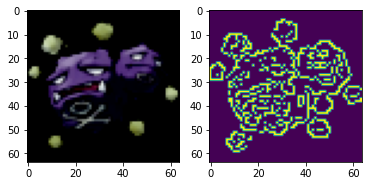

In [14]:
plt.subplot(121)
plt.imshow(im.permute(1,2,0).numpy())
plt.subplot(122)
plt.imshow(ed)
plt.show()

## **Часть 3.** Учим модель (12 баллов)

Теперь нужно собрать модели для генератора и дискриминатора, чтобы наша раскрашивалка могла учиться.

**Что надо сделать:**

1. Написать классы `Generator` и `Discriminator`. Оба, разумеется, должны наследоваться от `nn.Module`. Проверьте, что модели "переваривают" входные данные в нужном виде, а так же в нужном виде отдают результаты на выходе. (4 балла)

В курсе было рассмотрено много различных архитектур, которые могли бы подойти на роли генератора и дискриминатора. Для генератора можно взять UNet-подобную вещь, например.

2. Написать рутину обучения, запустить его, добиться визуально хороших результатов. (6 баллов)

Можно [подглядеть в оригинальный репозиторий](https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix/blob/master/models/pix2pix_model.py) и вдохновиться. 
Советуем использовать отдельную функцию для обучения на 1 батче / 1 эпохе.
Также для следующего пункта потребуется сохранять результаты работы генератора каждую эпоху (для пачки картинок с контурами).
Не забудьте построить графики изменения лоссов.
И вообще не забудьте разобраться в том, какой используется лосс!

3. Визуализировать динамику (или еще можно сказать *эволюцию*) работы генератора на разных эпохах. (2 балла)

Можно сделать анимацию. Главное - использовать одни и те же входные данные для консистентности между эпохами.
Напишите абзац текста о своих впечатлениях о проделанной работе и соображениях о том, как можно улучшить результаты.

In [87]:
#берем на вход инициализированную модель и у нее меняем веса
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [88]:
class Generator(nn.Module):
    def __init__(self, ngf):
        super(Generator, self).__init__()

        self.layers = nn.Sequential(
            # deconv on z 
            nn.ConvTranspose2d(image_size*image_size//4, ngf * 8, 4, 2, 1, bias=False), # (ngf*8) x 4 x 4
            nn.BatchNorm2d(ngf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False), #(ngf*4) x 8 x 8
            nn.BatchNorm2d(ngf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False), # (ngf*2) x 16 x 16
            nn.BatchNorm2d(ngf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False), # (ngf) x 32 x 32
            nn.BatchNorm2d(ngf),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.ConvTranspose2d(ngf, 3, 4, 2, 1, bias=False), # 3 x 64 x 64
            nn.Tanh()
        )

    def forward(self, input):
        return self.layers(input)

In [89]:
netG = Generator(ngf).to(device)

In [90]:
netG.apply(weights_init)

Generator(
  (layers): Sequential(
    (0): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2, inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.2, inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): LeakyReLU(negative_slope=0.2, inplace=True)


In [91]:
class Discriminator(nn.Module):
    def __init__(self, ndf):
        super(Discriminator, self).__init__()

        self.layers = nn.Sequential(
            # input  3 x 64 x 64
            nn.Conv2d(3, ndf, 4, 2, 1, bias=False),  # (ndf) x 32 x 32
            nn.LeakyReLU(0.2, inplace=True),
           
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False), # (ndf*2) x 16 x 16
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False), # (ndf*4) x 8 x 8
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False), # (ndf*8) x 4 x 4
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False), # 1
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.layers(input)

In [92]:
netD = Discriminator(ndf).to(device)
netD.apply(weights_init)

Discriminator(
  (layers): Sequential(
    (0): Conv2d(3, 48, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(48, 96, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(96, 192, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(192, 384, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(384, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)

In [93]:
criterion = nn.BCELoss()

#на этом батче из контуров будем отслеживать процесс улучшения генератора
fixed_edges = torch.tensor(np.array([paireddataset[i][1] for i in range(5)])).to(device)
fixed_imgs = torch.vstack([torch.unsqueeze(paireddataset[i][0],0) for i in range(5)])

real_label = 1.
fake_label = 0.

optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

In [95]:
num_epochs = 500

In [96]:
%%time
# списки для логов
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Training...")
for epoch in range(num_epochs):
    for i, data in enumerate(paireddataloader, 0):

        ############################
        # (1) Шаг дискриминатора: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Сперва реальный батч
        imgs, edges = data
        netD.zero_grad()
        real_batch = imgs.to(device)
        b_size = real_batch.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)

        # Forward и backward по реальному батчу
        output = netD(real_batch).view(-1)
        errD_real = criterion(output, label)
        errD_real.backward()
        D_x = output.mean().item() #средним ответ дискриминатора на реальных данных

        ## Теперь фейковый батч
        # Получаем выход генератора на границах картинок
        fake_batch = netG((edges/255).reshape(-1,image_size*image_size//4, 2, 2).to(device))
        label.fill_(fake_label)

        # Forward и backward по фейковому батчу
        output = netD(fake_batch.detach()).view(-1)
        errD_fake = criterion(output, label)
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        
        #собираем все градиенты и делаем шаг
        errD = errD_real + errD_fake
        optimizerD.step()

        ############################
        # (2) Шаг генератора: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # тонкий момент: фейковые лейблы в терминах генератора - реальные
        
        # мы обновили D, прогоним через обновленную сеть фейки ещё раз
        output = netD(fake_batch).view(-1)
        errG = criterion(output, label)
        errG.backward()
        D_G_z2 = output.mean().item() #смотрим как изменилось на том же фейке поведение дискриминатора
        optimizerG.step()

        # просто логи
        if i % 100 == 0:
            print('[%d/%d][%d/%d] Loss_D: %.4f Loss_G: %.4f  D(x): %.4f D(G(z)): %.4f -> %.4f'
                  % (epoch+1, num_epochs, i, len(paireddataloader), errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # сохраняем лоссы для будущего графика
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # сохраняем результаты на фиксированном входе генератора
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(paireddataloader)-1)):
            with torch.no_grad():
                fake = netG((fixed_edges/255).reshape(-1,image_size*image_size//4, 2, 2)).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1

Training...
[1/500][0/7] Loss_D: 1.5481 Loss_G: 4.3404  D(x): 0.4972 D(G(z)): 0.4897 -> 0.0243
[2/500][0/7] Loss_D: 3.8478 Loss_G: 7.3988  D(x): 0.7513 D(G(z)): 0.9468 -> 0.0009
[3/500][0/7] Loss_D: 0.8124 Loss_G: 9.3178  D(x): 0.8110 D(G(z)): 0.3109 -> 0.0003
[4/500][0/7] Loss_D: 1.5324 Loss_G: 12.0133  D(x): 0.9076 D(G(z)): 0.7225 -> 0.0000
[5/500][0/7] Loss_D: 0.5285 Loss_G: 8.8256  D(x): 0.7262 D(G(z)): 0.0451 -> 0.0002
[6/500][0/7] Loss_D: 2.0795 Loss_G: 10.3610  D(x): 0.2856 D(G(z)): 0.0010 -> 0.0000
[7/500][0/7] Loss_D: 1.1901 Loss_G: 11.1361  D(x): 0.9440 D(G(z)): 0.6613 -> 0.0000
[8/500][0/7] Loss_D: 0.6812 Loss_G: 6.5620  D(x): 0.6266 D(G(z)): 0.0535 -> 0.0015
[9/500][0/7] Loss_D: 2.3500 Loss_G: 4.8040  D(x): 0.2021 D(G(z)): 0.0409 -> 0.0092
[10/500][0/7] Loss_D: 1.1320 Loss_G: 5.7416  D(x): 0.7218 D(G(z)): 0.4473 -> 0.0036
[11/500][0/7] Loss_D: 1.0878 Loss_G: 4.6206  D(x): 0.6255 D(G(z)): 0.3223 -> 0.0129
[12/500][0/7] Loss_D: 1.7164 Loss_G: 4.2868  D(x): 0.6320 D(G(z)): 0.6

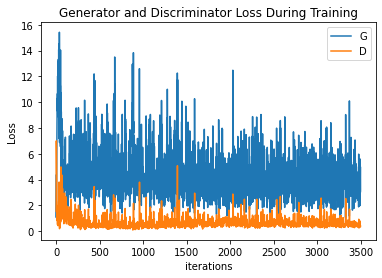

In [97]:
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

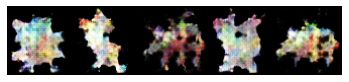

In [98]:
fig = plt.figure(figsize=(6, 6))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i, (1, 2, 0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, blit=True)

HTML(ani.to_jshtml())

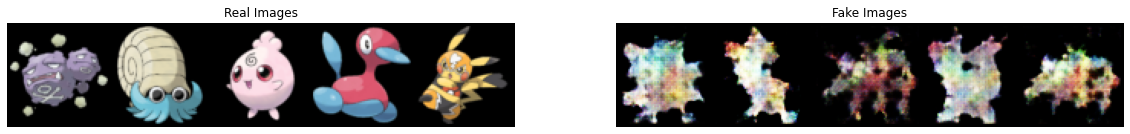

In [105]:
# Plot the real images
plt.figure(figsize=(20, 20))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(fixed_imgs, padding=2, normalize=True).cpu(),(1,2,0)))

plt.subplot(1, 2, 2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()

Генератор обучается довольно плохо. Видимо, это связано с затуханием градиентов. Можно использовать, например, WGAN, пробовать другие структруры самих сетей, чтобы улучшить результат. Причём результаты получились хуже, чем когда я просто подавал в генератор семплы из нормального распределения, а не контуры изображений

## **Бонус!** (10 баллов)

Давайте попробуем добавить ещё один рычаг контроля над GANом - в качестве условия будем передавать не только границы, но и основной цвет, которым мы хотим покемона покрасить. Ведь, как видно в примерах с сумками и туфлями, одни лишь границы не могут влиять на цветовую гамму. 

**Над чем тут нужно подумать:**

1. Как его извлекать из первоначальной картинки? Пишите словами, что думаете. (1 балл)
2. Как его передавать в модель? Он может быть как-то передан в закодированном виде на вход отдельно от границ, а может быть закодирован в той же картинке с границами. Что думаете? (1 балла)
3. Дальше нужно подобное вычисление основного цвета реализовать (в функции `get_main_colour(image)`). Визуализируйте результат работы функции для нескольких примеров из датасета. Обучите ваш Pix2Pix с этим нововведением. (6 баллов)
4. Покажите, как генератор выучился учитывать переданный цвет. Возьмите несколько входных картинок с контурами и пораскрашивайте их генератором в разные цвета. (2 балла)

In [ ]:
### YOUR CODE HERE

**Вот и всё. Какие же вы молодцы! :)**